In [1]:
from pipeline.environment.hardware import get_free_device

import math
from typing import Callable

import seaborn as sns
import torch
import torch.nn.functional as F
from einops import repeat
from flash_attn import flash_attn_func
from torch.nn.attention import SDPBackend, sdpa_kernel

In [2]:
sns.set_style('white')
torch.set_float32_matmul_precision('high')

In [3]:
device = get_free_device()
dtype = torch.bfloat16

In [4]:
def calc_attn_mask(seq_len: int, prefix_len: int, device: torch.device) -> torch.Tensor:
    mask = torch.tril(torch.ones(seq_len, seq_len, dtype=torch.bool))
    mask |= (torch.arange(seq_len) < prefix_len)
    return mask.to(device)

In [5]:
def attention_reference(query_states: torch.Tensor,
                        key_states: torch.Tensor,
                        value_states: torch.Tensor,
                        prefix_len: int,
                        ) -> tuple[torch.Tensor, torch.Tensor]:
    original_dtype = query_states.dtype
    query_states = query_states.float()
    key_states = key_states.float()
    value_states = value_states.float()

    key_states = repeat(key_states, 'b s h d -> b s (h g) d', g=query_states.shape[2] // key_states.shape[2])
    value_states = repeat(value_states, 'b s h d -> b s (h g) d', g=query_states.shape[2] // key_states.shape[2])
    d = query_states.shape[-1]

    scores = torch.einsum('bthd,bshd->bhts', query_states / math.sqrt(d), key_states)
    if prefix_len != 0:
        attention_mask = calc_attn_mask(query_states.shape[1], prefix_len, scores.device)
        attention_bias = torch.zeros_like(scores)
        attention_bias.masked_fill_(~attention_mask, -torch.inf)
        scores = scores + attention_bias

    attention = torch.softmax(scores, dim=-1).to(value_states.dtype)
    output = torch.einsum('bhts,bshd->bthd', attention, value_states)

    return output.to(original_dtype), attention.to(original_dtype)

In [6]:
def double_fa2(query_states: torch.Tensor,
               key_states: torch.Tensor,
               value_states: torch.Tensor,
               prefix_len: int,
               ) -> torch.Tensor:
    return torch.concat((
        flash_attn_func(
            q=query_states[:, :prefix_len],
            k=key_states[:, :prefix_len],
            v=value_states[:, :prefix_len],
            causal=False),
        flash_attn_func(
            q=query_states[:, prefix_len:],
            k=key_states,
            v=value_states,
            causal=True)
    ), dim=1)

In [7]:
def torch_sdpa(query_states: torch.Tensor,
               key_states: torch.Tensor,
               value_states: torch.Tensor,
               prefix_len: int,
               ) -> torch.Tensor:
    return F.scaled_dot_product_attention(
        query=query_states.transpose(1, 2),
        key=key_states.transpose(1, 2),
        value=value_states.transpose(1, 2),
        attn_mask=calc_attn_mask(query_states.shape[1], prefix_len, query_states.device),
    ).transpose(1, 2)

In [8]:
batch_size = 1
seq_len = 512
prefix_len = int(seq_len / 3)
num_heads = 16
head_dim = 128

In [9]:
q, k, v = torch.randn(3, batch_size, seq_len, num_heads, head_dim, dtype=dtype, device=device)

In [10]:
out_ref, attn_probs = attention_reference(q, k, v, prefix_len)
attn_probs = attn_probs[0, 0].float().cpu()

<Axes: >

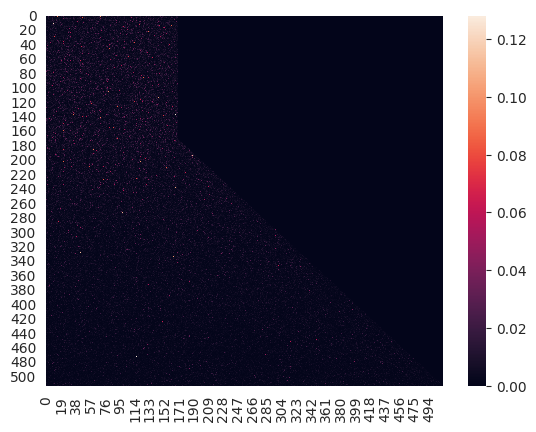

In [11]:
sns.heatmap(attn_probs)

<Axes: >

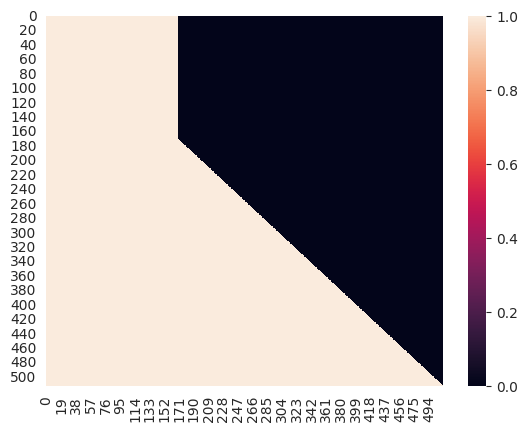

In [12]:
sns.heatmap(attn_probs > 0)

<Axes: >

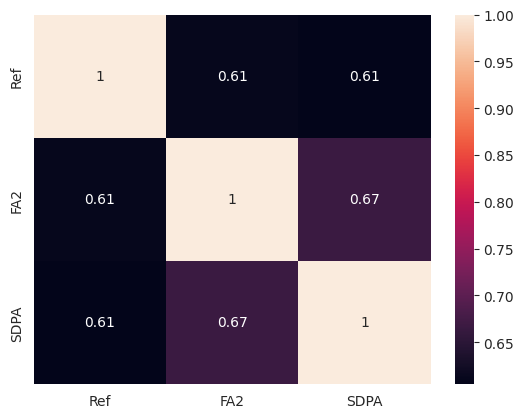

In [13]:
fa2_out = double_fa2(q, k, v, prefix_len)
sdpa_out = torch_sdpa(q, k, v, prefix_len)

outputs = [out_ref, fa2_out, sdpa_out]
labels = ['Ref', 'FA2', 'SDPA']
similarity_matrix = torch.empty(3, 3)

for i, out_1 in enumerate(outputs):
    for j, out_2 in enumerate(outputs):
        similarity_matrix[i, j] = torch.isclose(out_1, out_2).float().mean().item()

sns.heatmap(similarity_matrix, annot=True, xticklabels=labels, yticklabels=labels)

In [14]:
seq_len = 16384
prefix_len = int(seq_len / 3)

## Memory

In [15]:
torch.manual_seed(0)
torch.cuda.reset_peak_memory_stats(device)

In [16]:
q, k, v = torch.randn(3, batch_size, seq_len, num_heads, head_dim, dtype=dtype, device=device, requires_grad=True)
double_fa2(q, k, v, prefix_len).mean().backward()
torch.cuda.empty_cache()
double_fa2_memory_stats = torch.cuda.memory_stats(device)

In [17]:
torch.manual_seed(0)
torch.cuda.reset_peak_memory_stats(device)

In [18]:
q, k, v = torch.randn(3, batch_size, seq_len, num_heads, head_dim, dtype=dtype, device=device, requires_grad=True)
torch_sdpa(q, k, v, prefix_len).mean().backward()
torch.cuda.empty_cache()
torch_sdpa_memory_stats = torch.cuda.memory_stats(device)

In [19]:
double_fa2_memory_stats

OrderedDict([('active.all.allocated', 200),
             ('active.all.current', 6),
             ('active.all.freed', 194),
             ('active.all.peak', 19),
             ('active.large_pool.allocated', 105),
             ('active.large_pool.current', 6),
             ('active.large_pool.freed', 99),
             ('active.large_pool.peak', 14),
             ('active.small_pool.allocated', 95),
             ('active.small_pool.current', 0),
             ('active.small_pool.freed', 95),
             ('active.small_pool.peak', 7),
             ('active_bytes.all.allocated', 1993269760),
             ('active_bytes.all.current', 417464320),
             ('active_bytes.all.freed', 1575805440),
             ('active_bytes.all.peak', 621947392),
             ('active_bytes.large_pool.allocated', 1940541440),
             ('active_bytes.large_pool.current', 417464320),
             ('active_bytes.large_pool.freed', 1523077120),
             ('active_bytes.large_pool.peak', 620191744),
    

In [20]:
torch_sdpa_memory_stats

OrderedDict([('active.all.allocated', 217),
             ('active.all.current', 6),
             ('active.all.freed', 211),
             ('active.all.peak', 16),
             ('active.large_pool.allocated', 116),
             ('active.large_pool.current', 6),
             ('active.large_pool.freed', 110),
             ('active.large_pool.peak', 12),
             ('active.small_pool.allocated', 101),
             ('active.small_pool.current', 0),
             ('active.small_pool.freed', 101),
             ('active.small_pool.peak', 4),
             ('active_bytes.all.allocated', 3941560320),
             ('active_bytes.all.current', 417464320),
             ('active_bytes.all.freed', 3524096000),
             ('active_bytes.all.peak', 1289879552),
             ('active_bytes.large_pool.allocated', 3886731264),
             ('active_bytes.large_pool.current', 417464320),
             ('active_bytes.large_pool.freed', 3469266944),
             ('active_bytes.large_pool.peak', 1289879552),

## Runtime

In [21]:
torch.manual_seed(0)

In [22]:
%%timeit
q, k, v = torch.randn(3, batch_size, seq_len, num_heads, head_dim, dtype=dtype, device=device, requires_grad=True)
double_fa2(q, k, v, prefix_len).mean().backward()

25 ms ± 13.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
torch.manual_seed(0)

In [24]:
%%timeit
q, k, v = torch.randn(3, batch_size, seq_len, num_heads, head_dim, dtype=dtype, device=device, requires_grad=True)
torch_sdpa(q, k, v, prefix_len).mean().backward()

149 ms ± 687 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
